# Trial Store Performance Analysis

### Introduction

Retail companies often run store-level trials to understand how specific promotions or interventions affect sales and customer behavior. Evaluating these trials rigorously is essential to ensure that business decisions are based on evidence rather than assumptions.  

In this analysis, we focus on a promotional trial conducted in **stores 77, 86, and 88**, aiming to:

1. Measure the impact of the trial on **total sales**.
2. Determine whether any changes are driven by **more customers visiting the store** or **higher spending per customer**.
3. Identify appropriate **control stores** for a fair comparison.

This notebook follows a structured approach, from pre-trial performance comparison to trial-period evaluation, highlighting key insights for decision-making.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from statistics import stdev
from scipy.stats import t

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

### Load Data

In [2]:
data = pd.read_csv("QVI_data.csv")

In [3]:
data.head(3)

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget


### Select Control Stores

To properly evaluate the trial, we need to select **control stores** that are well-established and active throughout the observation period.  
Control stores should closely resemble each **trial store** before February 2019, based on:

- Total sales revenue
- Number of customers
- Average transactions per customer

In [4]:
# Create YearMonth
data['YEARMONTH'] = [''.join(x.split('-')[0:2]) for x in data.DATE]
data['YEARMONTH'] = pd.to_numeric(data['YEARMONTH'])

In [5]:
# Total Sales
Total_Sales= data.groupby(['STORE_NBR', 'YEARMONTH']).TOT_SALES.sum()

In [6]:
# Number of customers
no_Customers = data.groupby(['STORE_NBR', 'YEARMONTH']).LYLTY_CARD_NBR.nunique()

In [7]:
# Transactions per Customer
trans_per_customer = data.groupby(['STORE_NBR', 'YEARMONTH']).TXN_ID.nunique() / no_Customers

In [8]:
# Chips per Customer
chips_per_customer = data.groupby(['STORE_NBR', 'YEARMONTH']).PROD_QTY.sum() / data.groupby(['STORE_NBR', 'YEARMONTH']).TXN_ID.nunique()

In [9]:
# Average price per unit
average_price = Total_Sales / data.groupby(['STORE_NBR', 'YEARMONTH']).PROD_QTY.sum()

In [10]:
# Combine metrics
measureOverTime = pd.concat([Total_Sales, no_Customers, trans_per_customer, chips_per_customer, average_price], axis=1)
measureOverTime.columns = ['Total Sales', 'no_Customers', 'trans_per_customer', 'chips_per_customer', 'average_price']
measureOverTime.reset_index(inplace=True)
measureOverTime.head(3)

,STORE_NBR,YEARMONTH,Total Sales,no_Customers,trans_per_customer,chips_per_customer,average_price
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333


In [11]:
# Filter to the pre-trial period and stores with full observation periods
data1 = pd.pivot_table(data, index='STORE_NBR', columns='YEARMONTH', values='TXN_ID', aggfunc='count')

# Store numbers that do not have full observation periods
null_stores = data1[data1.isnull().any(axis=1)].index.tolist()
null_stores

[11, 31, 44, 76, 85, 92, 117, 193, 206, 211, 218, 252]

In [12]:
# Filter out the null stores
measureOverTime = measureOverTime[~measureOverTime['STORE_NBR'].isin(null_stores)]

In [13]:
# Pre-trial period before 201902
preTrialMeasures = measureOverTime[measureOverTime['YEARMONTH'] < 201902]

To systematically rank potential control stores, we create a **reusable function**. This function evaluates each candidate based on:

1. **Correlation of performance trends** – how closely the monthly sales patterns follow the trial store.
2. **Standardized magnitude distance** – based on absolute differences in performance metrics.

Using this function ensures we select the most representative control store for each trial store, enabling fair and reliable comparisons during the trial period.

In [14]:
# Functions for control store selection
# Create a function to calculate correlation for a measure
def calculateCorrelation(inputTable, metricCol, trial_store):
    storeNumbers = inputTable['STORE_NBR'].unique()
    x = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metricCol].reset_index(drop=True)
    calcCorrTable = []
    for i in storeNumbers:
        y = inputTable.loc[inputTable['STORE_NBR'] == i, metricCol].reset_index(drop=True)
        corr = y.corr(x)
        calcCorrTable.append({'Store1': trial_store, 'Store2': i, 'corr_measure': corr})
    return pd.DataFrame(calcCorrTable)

# Create a function to calculate a standardised magnitude distance for a measure
def calculateMagnitudeDistance(inputTable, metricCol, trial_store):
    storeNumbers = inputTable['STORE_NBR'].unique()
    x = inputTable.loc[inputTable['STORE_NBR'] == trial_store, metricCol].reset_index(drop=True)
    calcDistTable = []
    for i in storeNumbers:
        y = inputTable.loc[inputTable['STORE_NBR'] == i, metricCol].reset_index(drop=True)
        z = abs(x - y)
        A = np.mean(1 - (z - z.min()) / (z.max() - z.min()))
        calcDistTable.append({'Store1': trial_store, 'Store2': i, 'Magnitude': A})
    return pd.DataFrame(calcDistTable)

### Trial Store 77

Using the ranking functions described above, we identify the most representative control stores for store 77.  
The selection is based on similarity in **monthly total sales** and **monthly number of customers**, producing four scores: two for total sales and two for total customers.  

We then use these scores to choose the best-matched control store and compare performance during the trial period.

In [15]:
trial_store_77 = 77

In [16]:
# Correlation & magnitude
corr_Sales_77 = calculateCorrelation(preTrialMeasures, 'Total Sales', trial_store_77)
magnitude_Sales_77 = calculateMagnitudeDistance(preTrialMeasures, 'Total Sales', trial_store_77)

corr_Customers_77 = calculateCorrelation(preTrialMeasures, 'no_Customers', trial_store_77)
magnitude_Customers_77 = calculateMagnitudeDistance(preTrialMeasures, 'no_Customers', trial_store_77)

In [17]:
score_Sales_77 = pd.concat([corr_Sales_77, magnitude_Sales_77['Magnitude']], axis=1)
score_Sales_77.head(3)

,Store1,Store2,corr_measure,Magnitude
0,77,1,0.075218,0.408163
1,77,2,-0.263079,0.590119
2,77,3,0.806644,0.522914


In [18]:
score_Customers_77 = pd.concat([corr_Customers_77, magnitude_Customers_77['Magnitude']], axis=1)
score_Customers_77.head(3)

,Store1,Store2,corr_measure,Magnitude
0,77,1,0.322168,0.663866
1,77,2,-0.572051,0.471429
2,77,3,0.834207,0.489796


To rank the potential control stores, we combine all the scores calculated by our function into a **composite score**. A straightforward approach is to take the **average of the correlation and magnitude scores** for each metric.  

If we want to **emphasize trend similarity**, we can give more weight to the correlation score;  
conversely, if we care more about the **absolute size of the metrics**, we can reduce the weight of the correlation score.

In [19]:
# Weighted score
corr_weight = 0.5
score_Sales_77['scoreSales'] = corr_weight * score_Sales_77['corr_measure'] + (1 - corr_weight) * score_Sales_77['Magnitude']
score_Customers_77['scoreCustomers'] = corr_weight * score_Customers_77['corr_measure'] + (1 - corr_weight) * score_Customers_77['Magnitude']

# Set index
score_Sales_77.set_index(['Store1','Store2'], inplace=True)
score_Customers_77.set_index(['Store1','Store2'], inplace=True)

# Combine scores across the drivers
score_Control_77 = pd.concat([score_Sales_77['scoreSales'], score_Customers_77['scoreCustomers']], axis=1)

# Add a new column 'finalControlScore' to 'score_Control'
score_Control_77['finalControlScore'] = 0.5 * (score_Control_77['scoreSales'] + score_Control_77['scoreCustomers'])
score_Control_77.sort_values(by='finalControlScore', ascending=False).head(5)

scoreSales  scoreCustomers  finalControlScore
Store1 Store2                                               
77     233       0.697290        0.816607           0.756949
       71        0.789497        0.663123           0.726310
       84        0.656972        0.715000           0.685986
       119       0.636046        0.729729           0.682887
       115       0.708347        0.645155           0.676751

In [20]:
# Select control store for trial store 77
control_store_77 = score_Control_77['finalControlScore'].idxmax()[1]
print("Control store for Trial Store 77:", control_store_77)

Control store for Trial Store 77: 233


After identifying a suitable control store, we can **visually inspect** whether the key drivers are indeed similar during the **pre-trial period**. We start by examining **total sales** to see if the trends of the trial store and its control store align.

In [21]:
# Trial and control assignment
pastSales_77 = preTrialMeasures.copy()
pastSales_77['store_type'] = pastSales_77['STORE_NBR'].apply(lambda x: 'Trial Store' if x==trial_store_77 else ('Control Store' if x==control_store_77 else 'Other Stores'))
pastSales_77['TransactionMonth'] = pd.to_datetime(pastSales_77['YEARMONTH'].astype(str), format='%Y%m')
pastSales_77['Month'] = pastSales_77['TransactionMonth'].dt.month_name().str[:3]
pastSales_77.head(3)

,STORE_NBR,YEARMONTH,Total Sales,no_Customers,trans_per_customer,chips_per_customer,average_price,store_type,TransactionMonth,Month
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01,Jul
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01,Aug
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01,Sep


In [22]:
# Plot Total Sales pre-trial
combinePlot_77 = pd.concat([
    pastSales_77[pastSales_77['store_type']=='Control Store'].set_index('Month')['Total Sales'].rename('Control Store Sales'),
    pastSales_77[pastSales_77['store_type']=='Trial Store'].set_index('Month')['Total Sales'].rename('Trial Store Sales'),
    pastSales_77[pastSales_77['store_type']=='Other Stores'].groupby('Month')['Total Sales'].mean().rename('Other Stores Sales')], axis=1)

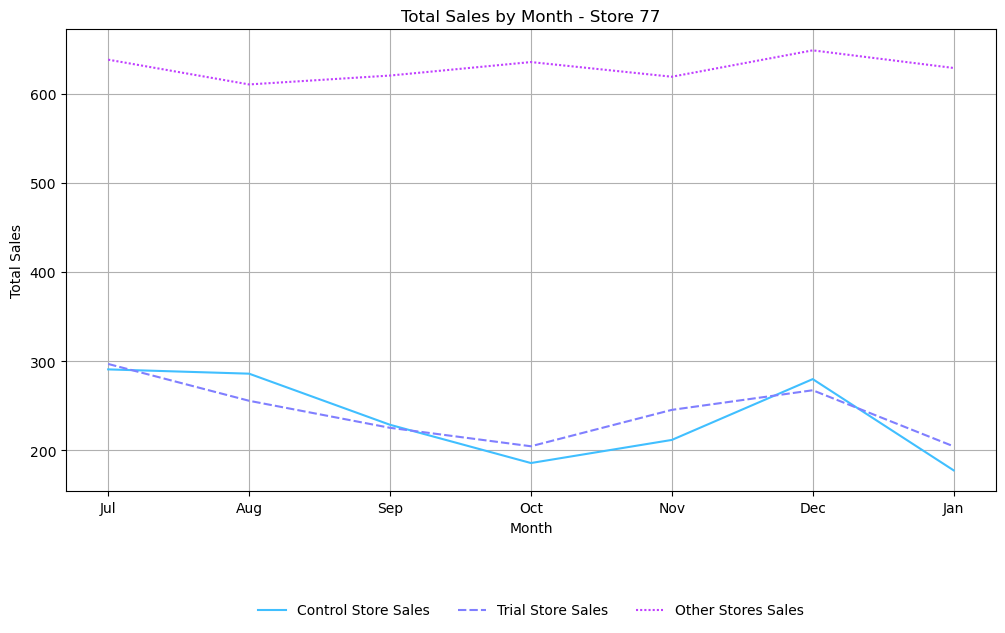

In [23]:
plt.figure(figsize=(12,6))
ax_77 = sns.lineplot(data=combinePlot_77, palette="cool")
sns.move_legend(ax_77, "lower center", bbox_to_anchor=(0.5, -.3), ncol=3, frameon=False)
plt.title("Total Sales by Month - Store 77")
plt.ylabel("Total Sales")
plt.grid()
plt.show()

Next, we’ll visually compare customer count trends between the trial store, the control store, and other stores. This helps us confirm whether the selected control store behaves similarly to the trial store before the trial period.

In [24]:
# Filter each store type
control_Customer_Plot_77 = pastSales_77.loc[pastSales_77['store_type'] == 'Control Store', ['Month', 'no_Customers']].set_index('Month')
trial_Customer_Plot_77 = pastSales_77.loc[pastSales_77['store_type'] == 'Trial Store', ['Month', 'no_Customers']].set_index('Month')
other_Customer_Plot_77 = pastSales_77.loc[pastSales_77['store_type'] == 'Other Stores', ['Month', 'no_Customers']].groupby('Month').mean()

# Rename columns for clarity
control_Customer_Plot_77.rename(columns={'no_Customers':'Control Store Customers'}, inplace=True)
trial_Customer_Plot_77.rename(columns={'no_Customers':'Trial Store Customers'}, inplace=True)
other_Customer_Plot_77.rename(columns={'no_Customers':'Other Stores Customers'}, inplace=True)

# Combine into one DataFrame
combine_Customer_Plot_77 = pd.concat([control_Customer_Plot_77, trial_Customer_Plot_77, other_Customer_Plot_77], axis=1)

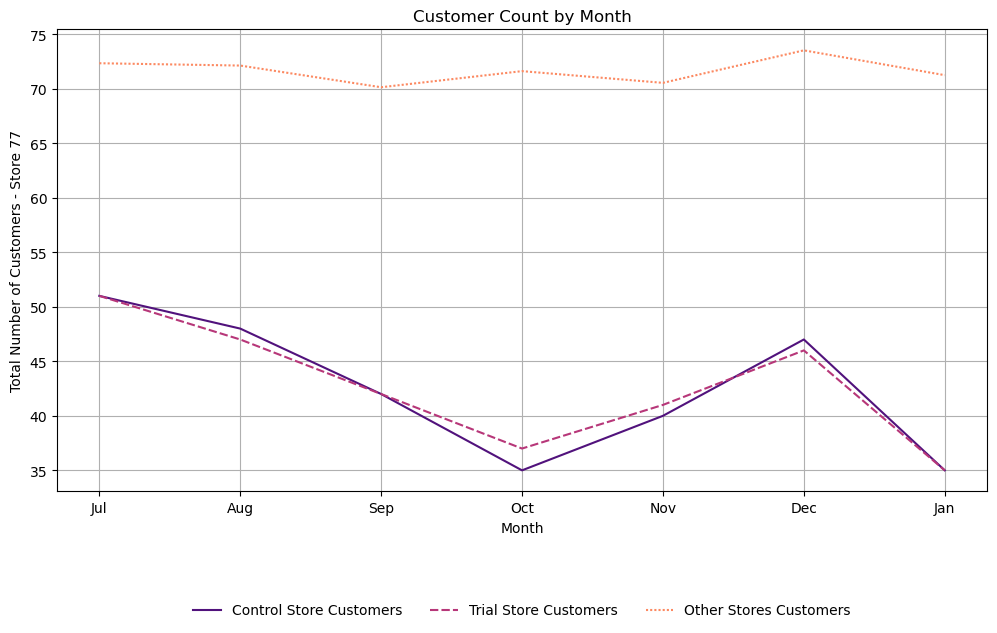

In [25]:
plt.figure(figsize=(12,6))
ax1_77 = sns.lineplot(data=combine_Customer_Plot_77, palette="magma")
sns.move_legend(ax1_77, "lower center", bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False)
plt.ylabel("Total Number of Customers - Store 77")
plt.title('Customer Count by Month')
plt.grid()
plt.show()

#### Trial Assessment: Sales for Store 77

The trial period runs from the start of March 2019 to June 2019. We now want to examine whether there has been an uplift in overall chip sales.  

To make a fair comparison, we first scale the control store’s sales to a level comparable to the trial store. This adjustment controls for any baseline differences between the two stores prior to the trial period.

In [26]:
measureOverTimeSales_77 = measureOverTime.copy()
measureOverTimeSales_77['TransactionMonth'] = pd.to_datetime(measureOverTimeSales_77['YEARMONTH'].astype(str), format='%Y%m')

In [27]:
# Scale pre-trial control sales to match trial store
trial_sales_sum_77 = pastSales_77[pastSales_77['store_type']=='Trial Store']['Total Sales'].sum()
control_sales_sum_77 = pastSales_77[pastSales_77['store_type']=='Control Store']['Total Sales'].sum()
scalingFactorForControlSales_77 = trial_sales_sum_77 / control_sales_sum_77
scalingFactorForControlSales_77

np.float64(1.023617303289553)

In [28]:
# Apply scaling factor to control store in full measureOverTime
scaledControlSales_77 = measureOverTimeSales_77[measureOverTimeSales_77['STORE_NBR']==control_store_77].copy()
scaledControlSales_77['controlSales'] = scaledControlSales_77['Total Sales'] * scalingFactorForControlSales_77
scaledControlSales_77['TransactionMonth'] = pd.to_datetime(scaledControlSales_77['YEARMONTH'].astype(str), format='%Y%m')
scaledControlSales_77.head(3)

,STORE_NBR,YEARMONTH,Total Sales,no_Customers,trans_per_customer,chips_per_customer,average_price,TransactionMonth,controlSales
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,2018-07-01,297.565550
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,2018-08-01,292.652187
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,2018-09-01,233.998916


Now that we have comparable sales figures for the control store, we can calculate the **percentage difference** between the scaled control sales and the trial store’s sales during the trial period.  

This metric helps us quantify the uplift in sales attributable to the trial, while accounting for pre-existing differences between the stores.

In [29]:
# Calculate percentage difference between trial and scaled control
trial_sales_series_77 = measureOverTimeSales_77[measureOverTimeSales_77['STORE_NBR']==trial_store_77]['Total Sales'].reset_index(drop=True)

percentageDiffSales_77 = scaledControlSales_77[['YEARMONTH','controlSales']].reset_index(drop=True)
percentageDiffSales_77 = pd.concat([percentageDiffSales_77, trial_sales_series_77], axis=1)
percentageDiffSales_77.rename(columns={'Total Sales':'Trial_Sales'}, inplace=True)
percentageDiffSales_77['percentageDiff'] = abs(percentageDiffSales_77['controlSales'] - percentageDiffSales_77['Trial_Sales']) / percentageDiffSales_77['controlSales']
percentageDiffSales_77.head(3)

,YEARMONTH,controlSales,Trial_Sales,percentageDiff
0,201807,297.565550,296.8,0.002573
1,201808,292.652187,255.5,0.126950
2,201809,233.998916,225.2,0.037602


Assuming the **null hypothesis** that the trial period behaves the same as the pre-trial period, we calculate the **standard deviation** from the scaled percentage differences observed in the pre-trial period.  

This allows us to understand the normal variation in sales differences before the trial, which is essential for assessing whether any observed uplift during the trial is statistically significant.

In [30]:
# Standard deviation from pre-trial period
stdDevSales_77 = stdev(percentageDiffSales_77[percentageDiffSales_77['YEARMONTH']<201902]['percentageDiff'])
stdDevSales_77

0.049940762641425364

In [31]:
# Note that there are 8 months in the pre-trial period - 1
degreesOfFreedom_77 = 7

In [32]:
# Calculate t-values for trial months (Feb-Apr 2019)
percentageDiffSales_77['tValue'] = (percentageDiffSales_77['percentageDiff'] - 0) / stdDevSales_77
t_values_trial_77 = percentageDiffSales_77[(percentageDiffSales_77['YEARMONTH']>201901) & (percentageDiffSales_77['YEARMONTH']<201905)]['tValue']
print("t-values for trial months:", t_values_trial_77.tolist())

t-values for trial months: [1.183534397947827, 7.339115674164716, 12.476373249392271]


In [33]:
# 95th percentile of t distribution
t95_77 = t.isf(0.05, degreesOfFreedom_77)
print("95th percentile of t-distribution:", t95_77)

95th percentile of t-distribution: 1.8945786050613054


We can observe that the **t-value** is much larger than the 95th percentile value of the t-distribution for March and April. This indicates that the increase in sales at the trial store during these months is **statistically significant** compared to the control store.  

To make this insight more intuitive, we can create a **visual comparison** by plotting:  
- Sales of the control store  
- Sales of the trial store  
- The 95th percentile of the control store’s sales  

This helps us clearly see how the trial store’s performance deviates from expected levels.

In [34]:
# Control store confidence interval
controlSales_77 = scaledControlSales_77[['TransactionMonth','controlSales']].copy()
controlSales_77.set_index('TransactionMonth', inplace=True)
controlSales_77.rename(columns={'controlSales':'Control Sales'}, inplace=True)

# Control store 95th percentile
controlSales_77['Control 95th percentile'] = controlSales_77['Control Sales'] * (1 + stdDevSales_77*2)

# Control store 5th percentile
controlSales_77['Control 5th percentile'] = controlSales_77['Control Sales'] * (1 - stdDevSales_77*2)

In [35]:
# Merge trial sales
trialSales_77 = measureOverTimeSales_77[measureOverTimeSales_77['STORE_NBR']==trial_store_77][['TransactionMonth','Total Sales']].copy()
trialSales_77.set_index('TransactionMonth', inplace=True)
trialSales_77.rename(columns={'Total Sales':'Trial Sales'}, inplace=True)

trialAssessment_77 = pd.merge(controlSales_77, trialSales_77, left_index=True, right_index=True)
trialAssessment_77.head(3)

,Control Sales,Control 95th percentile,Control 5th percentile,Trial Sales
TransactionMonth,,,,
2018-07-01,297.565550,327.286851,267.844249,296.8
2018-08-01,292.652187,321.882734,263.421640,255.5
2018-09-01,233.998916,257.371084,210.626747,225.2


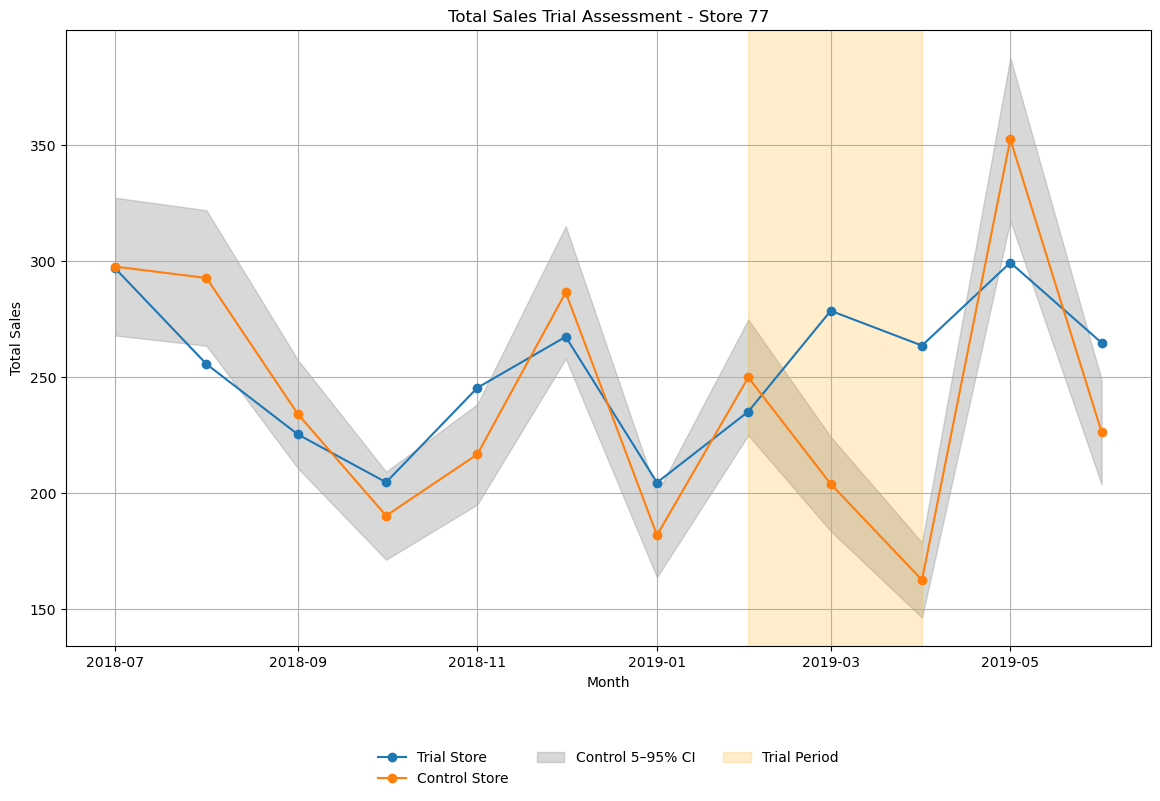

In [36]:
plt.figure(figsize=(14,8))

# Plot Trial Store and Control Store
plt.plot(trialAssessment_77.index, trialAssessment_77['Trial Sales'], label='Trial Store', marker='o')
plt.plot(trialAssessment_77.index, trialAssessment_77['Control Sales'], label='Control Store', marker='o')

# Shading area for confidence interval
plt.fill_between(trialAssessment_77.index, trialAssessment_77['Control 5th percentile'], trialAssessment_77['Control 95th percentile'], 
                 color='gray', alpha=0.3, label='Control 5–95% CI')

# Highlight trial period
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-01'), color='orange', alpha=0.2, label='Trial Period')

plt.title('Total Sales Trial Assessment - Store 77')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.show()

The **trial period** is highlighted in **orange**.

The results indicate that **store 77’s trial performance** differs significantly from its control store, falling **outside the control store’s 5%–95% confidence interval** in two of the three trial months. This suggests a clear impact of the trial, with overall performance showing an upward trend.

#### Trial Assessment: Customer for Store 77

Next, we’ll assess the trial’s impact on the **number of customers** to see whether any observed sales uplift is driven by **higher footfall** or by **more spending per customer**.


In [37]:
# Scale pre‐trial control customers to match pre‐trial trial store customers
trial_customers_77 = pastSales_77[pastSales_77['store_type']=='Trial Store']['no_Customers'].sum()
control_customers_77 = pastSales_77[pastSales_77['store_type']=='Control Store']['no_Customers'].sum()
scalingFactorForControlCust_77 = trial_customers_77 / control_customers_77
scalingFactorForControlCust_77

np.float64(1.0033557046979866)

In [38]:
# Apply the scaling factor
scaledControlCustomers_77 = measureOverTimeSales_77[measureOverTimeSales_77['STORE_NBR']==control_store_77].copy()
scaledControlCustomers_77['Control_Customers'] = scaledControlCustomers_77['no_Customers'] * scalingFactorForControlCust_77
scaledControlCustomers_77['TransactionMonth'] = pd.to_datetime(scaledControlCustomers_77['YEARMONTH'].astype(str), format='%Y%m')
scaledControlCustomers_77.head(3)

,STORE_NBR,YEARMONTH,Total Sales,no_Customers,trans_per_customer,chips_per_customer,average_price,TransactionMonth,Control_Customers
2699,233,201807,290.7,51,1.058824,1.629630,3.303409,2018-07-01,51.171141
2700,233,201808,285.9,48,1.041667,1.600000,3.573750,2018-08-01,48.161074
2701,233,201809,228.6,42,1.071429,1.555556,3.265714,2018-09-01,42.140940


In [39]:
# Calculate the percentage difference between scaled control sales and trial sales
trial_customers_series_77 = measureOverTimeSales_77[measureOverTimeSales_77['STORE_NBR']==trial_store_77]['no_Customers'].reset_index(drop=True)

percentageDiffCust_77 = scaledControlCustomers_77[['YEARMONTH','Control_Customers']].reset_index(drop=True)
percentageDiffCust_77 = pd.concat([percentageDiffCust_77, trial_customers_series_77], axis=1)
percentageDiffCust_77.rename(columns={'no_Customers':'Trial_Customers'}, inplace=True)
percentageDiffCust_77['percentageDiff'] = abs(percentageDiffCust_77['Control_Customers'] - percentageDiffCust_77['Trial_Customers']) / percentageDiffCust_77['Control_Customers']
percentageDiffCust_77.head(3)

,YEARMONTH,Control_Customers,Trial_Customers,percentageDiff
0,201807,51.171141,51,0.003344
1,201808,48.161074,47,0.024108
2,201809,42.140940,42,0.003344


In [40]:
# Standard deviation and t-values
stdDevCust_77 = stdev(percentageDiffCust_77[percentageDiffCust_77['YEARMONTH']<201902]['percentageDiff'])
percentageDiffCust_77['T_value'] = (percentageDiffCust_77['percentageDiff'] - 0) / stdDevCust_77

In [41]:
# Control customer confidence interval
controlCustomers_77 = scaledControlCustomers_77[['TransactionMonth','Control_Customers']].copy()
controlCustomers_77.set_index('TransactionMonth', inplace=True)
controlCustomers_77.rename(columns = {'Control_Customers':'Control Customers'}, inplace=True)
# Control store 95th percentile
controlCustomers_77['Control 95th % CI'] = controlCustomers_77['Control Customers'] * (1 + stdDevCust_77*2)
# Control store 5th percentile
controlCustomers_77['Control 5th % CI'] = controlCustomers_77['Control Customers'] * (1 - stdDevCust_77*2)

trialCustomers_77 = measureOverTimeSales_77[measureOverTimeSales_77['STORE_NBR']==trial_store_77][['TransactionMonth','no_Customers']].copy()
trialCustomers_77.set_index('TransactionMonth', inplace=True)
trialCustomers_77.rename(columns={'no_Customers':'Trial Customers'}, inplace=True)

# Merge trial store as well to the control store dataframe
trial_77_Customer_Assessment = pd.merge(controlCustomers_77, trialCustomers_77, left_index=True, right_index=True)
trial_77_Customer_Assessment.head(3)

,Control Customers,Control 95th % CI,Control 5th % CI,Trial Customers
TransactionMonth,,,,
2018-07-01,51.171141,53.037941,49.304341,51
2018-08-01,48.161074,49.918062,46.404086,47
2018-09-01,42.140940,43.678304,40.603575,42


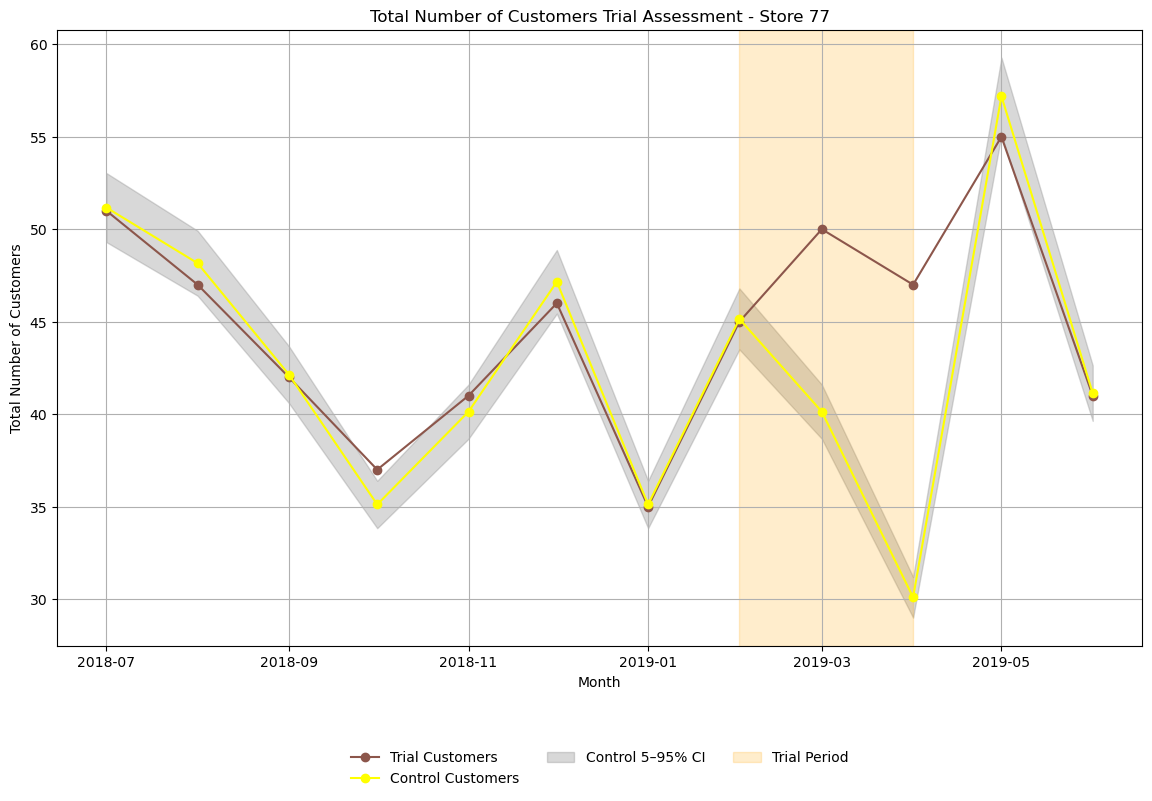

In [42]:
plt.figure(figsize=(14,8))

# Plot Trial Store and Control Store
plt.plot(trial_77_Customer_Assessment.index, trial_77_Customer_Assessment['Trial Customers'], label='Trial Customers', marker='o', color='tab:brown')
plt.plot(trial_77_Customer_Assessment.index, trial_77_Customer_Assessment['Control Customers'], label='Control Customers', marker='o', color='yellow')

# Shading area for confidence interval
plt.fill_between(trial_77_Customer_Assessment.index, trial_77_Customer_Assessment['Control 5th % CI'], trial_77_Customer_Assessment['Control 95th % CI'],
                 color='gray', alpha=0.3, label='Control 5–95% CI')

# Highlight trial period
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-01'), color='orange', alpha=0.2, label='Trial Period')

plt.title('Total Number of Customers Trial Assessment - Store 77')
plt.xlabel('Month')
plt.ylabel('Total Number of Customers')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.show()

Customer assessment for trial store 77 also shows a significant difference compared to its control store. Its performance falls outside the 5%–95% confidence interval of the control store for two of the three trial months. Total sales are above the confidence interval and have shown a gradual increase, although the change is not statistically significant.

We will repeat the process of identifying the most suitable control store and evaluating the trial’s impact for the remaining two trial stores.

### Trial Store 86

In [43]:
trial_store_86 = 86

# Correlation & Magnitude
corr_Sales_86 = calculateCorrelation(preTrialMeasures, 'Total Sales', trial_store_86)
magnitude_Sales_86 = calculateMagnitudeDistance(preTrialMeasures, 'Total Sales', trial_store_86)

corr_Customers_86 = calculateCorrelation(preTrialMeasures, 'no_Customers', trial_store_86)
magnitude_Customers_86 = calculateMagnitudeDistance(preTrialMeasures, 'no_Customers', trial_store_86)

In [44]:
score_Sales_86 = pd.concat([corr_Sales_86, magnitude_Sales_86['Magnitude']], axis=1)
score_Sales_86.head(3)

,Store1,Store2,corr_measure,Magnitude
0,86,1,0.445632,0.488334
1,86,2,-0.403835,0.321131
2,86,3,-0.261284,0.507515


In [45]:
score_Customers_86 = pd.concat([corr_Customers_86, magnitude_Customers_86['Magnitude']], axis=1)
score_Customers_86.head(3)

,Store1,Store2,corr_measure,Magnitude
0,86,1,0.485831,0.510204
1,86,2,-0.086161,0.428571
2,86,3,-0.353786,0.563025


In [46]:
# Create a combined score composed of correlation and magnitude
# Weighted score
corr_weight = 0.5
score_Sales_86['scoreSales'] = corr_weight * score_Sales_86['corr_measure'] + (1 - corr_weight) * score_Sales_86['Magnitude']
score_Customers_86['scoreCustomers'] = corr_weight * score_Customers_86['corr_measure'] + (1 - corr_weight) * score_Customers_86['Magnitude']

score_Sales_86.set_index(['Store1', 'Store2'], inplace=True)
score_Customers_86.set_index(['Store1', 'Store2'], inplace=True)

# Combine scores across the drivers
score_Control_86 = pd.concat([score_Sales_86['scoreSales'], score_Customers_86['scoreCustomers']], axis=1)

# Add a new column 'finalControlScore' to 'score_Control'
score_Control_86['finalControlScore'] = 0.5 * (score_Control_86['scoreSales'] + score_Control_86['scoreCustomers'])
score_Control_86.sort_values(by='finalControlScore', ascending=False).head(5)

scoreSales  scoreCustomers  finalControlScore
Store1 Store2                                               
86     155       0.808106        0.733343           0.770724
       109       0.697120        0.742532           0.719826
       114       0.631393        0.663384           0.647389
       225       0.601841        0.684356           0.643099
       138       0.593296        0.660565           0.626930

In [47]:
# Select control store for trial store 86
control_store_86 = score_Control_86['finalControlScore'].idxmax()[1]
print("Control store for Trial Store 86:", control_store_86)

Control store for Trial Store 86: 155


It appears that Store 155 will serve as the control store for Trial Store 86. Once again, let's visually inspect whether the key drivers were similar during the pre-trial period, starting with total sales.

In [48]:
# Trial and control assignment
pastSales_86 = preTrialMeasures.copy()
pastSales_86['store_type'] = pastSales_86['STORE_NBR'].apply(
    lambda x: 'Trial Store' if x==trial_store_86 else ('Control Store' if x==control_store_86 else 'Other Stores'))

pastSales_86['TransactionMonth'] = pd.to_datetime(pastSales_86['YEARMONTH'].astype(str), format='%Y%m')
pastSales_86['Month'] = pastSales_86['TransactionMonth'].dt.month_name().str[:3]
pastSales_86.head(3)

,STORE_NBR,YEARMONTH,Total Sales,no_Customers,trans_per_customer,chips_per_customer,average_price,store_type,TransactionMonth,Month
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01,Jul
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01,Aug
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01,Sep


In [49]:
# Plot Total Sales pre-trial
combinePlot_86 = pd.concat([
    pastSales_86[pastSales_86['store_type']=='Control Store'].set_index('Month')['Total Sales'].rename('Control Store Sales'),
    pastSales_86[pastSales_86['store_type']=='Trial Store'].set_index('Month')['Total Sales'].rename('Trial Store Sales'),
    pastSales_86[pastSales_86['store_type']=='Other Stores'].groupby('Month')['Total Sales'].mean().rename('Other Stores Sales')], axis=1)

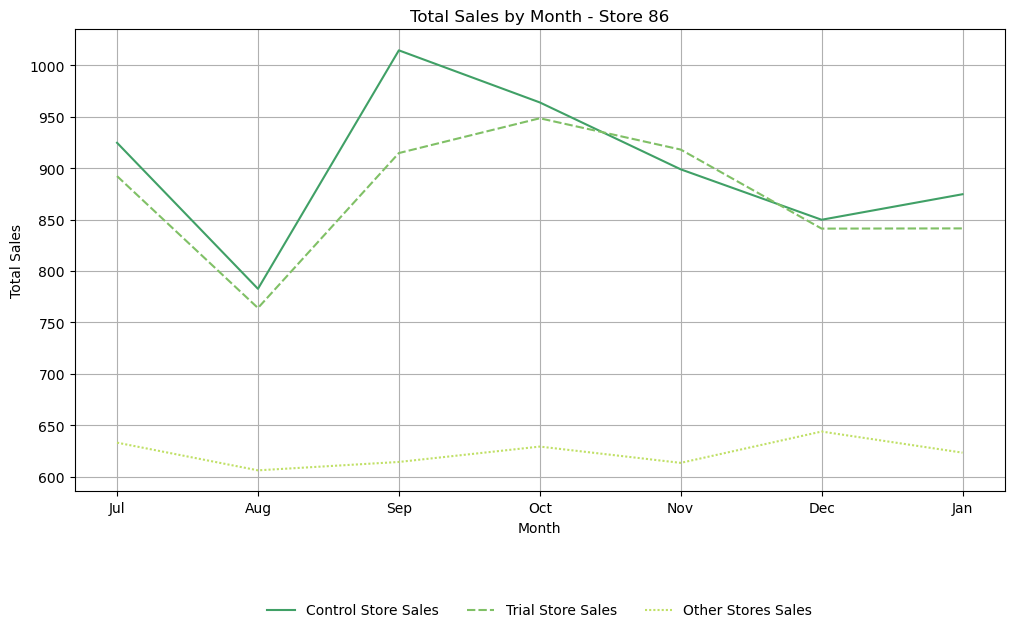

In [50]:
plt.figure(figsize=(12,6))
ax_86 = sns.lineplot(data=combinePlot_86, palette="summer")
sns.move_legend(ax_86, "lower center", bbox_to_anchor=(0.5, -.3), ncol=3, frameon=False)
plt.title("Total Sales by Month - Store 86")
plt.ylabel("Total Sales")
plt.grid()
plt.show()

Great — sales trends appear to be similar.  

Next, we visually compare **customer count trends** between the trial store, its control store, and other stores.

In [51]:
# Plot Customers
# Filter each store type
control_Customer_Plot_86 = pastSales_86.loc[pastSales_86['store_type'] == 'Control Store', ['Month', 'no_Customers']].set_index('Month')
trial_Customer_Plot_86 = pastSales_86.loc[pastSales_86['store_type'] == 'Trial Store', ['Month', 'no_Customers']].set_index('Month')
other_Customer_Plot_86 = pastSales_86.loc[pastSales_86['store_type'] == 'Other Stores', ['Month', 'no_Customers']].groupby('Month').mean()

# Rename
control_Customer_Plot_86.rename(columns={'no_Customers':'Control Store Customers'}, inplace=True)
trial_Customer_Plot_86.rename(columns={'no_Customers':'Trial Store Customers'}, inplace=True)
other_Customer_Plot_86.rename(columns={'no_Customers':'Other Stores Customers'}, inplace=True)

# Combine into one DataFrame
combine_Customer_Plot_86 = pd.concat([control_Customer_Plot_86, trial_Customer_Plot_86, other_Customer_Plot_86], axis=1)

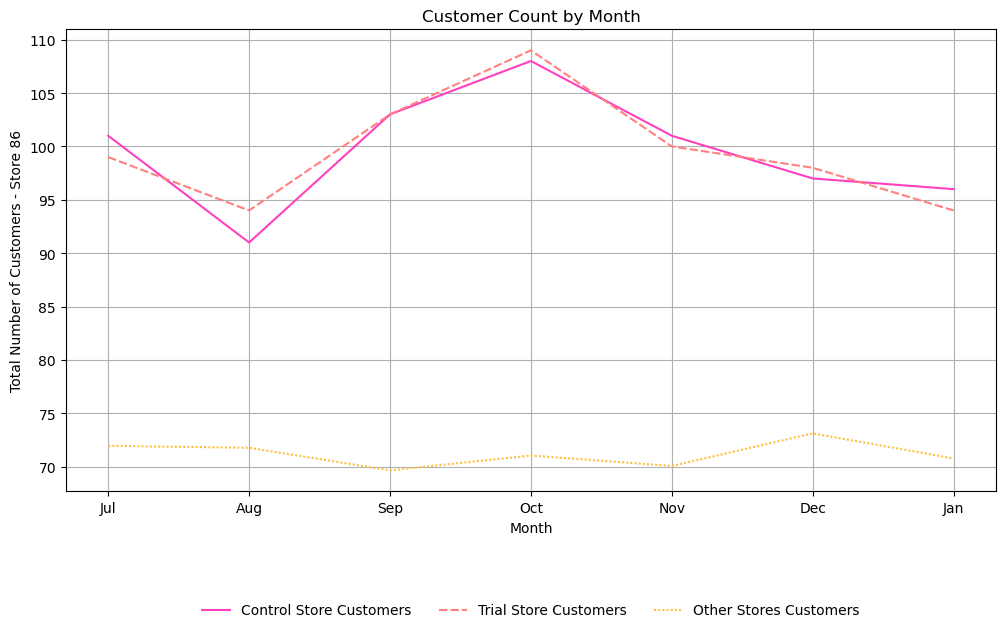

In [52]:
plt.figure(figsize=(12,6))
ax1_86 = sns.lineplot(data=combine_Customer_Plot_86, palette="spring")
sns.move_legend(ax1_86, "lower center", bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False)
plt.ylabel("Total Number of Customers - Store 86")
plt.title('Customer Count by Month')
plt.grid()
plt.show()

Good — the trend in the number of customers is also similar between the trial store and its control store.  
Next, we will assess the impact of the trial on **sales**.

#### Trial Assessment: Sales for Store 86

In [53]:
measureOverTimeSales_86 = measureOverTime.copy()
measureOverTimeSales_86['TransactionMonth'] = pd.to_datetime(measureOverTimeSales_86['YEARMONTH'].astype(str), format='%Y%m')

In [54]:
# Scale pre‐trial control sales to match pre‐trial trial store sales
trial_sales_sum_86 = pastSales_86[pastSales_86['store_type']=='Trial Store']['Total Sales'].sum()
control_sales_sum_86 = pastSales_86[pastSales_86['store_type']=='Control Store']['Total Sales'].sum()
scalingFactorForControlSales_86 = trial_sales_sum_86 / control_sales_sum_86
scalingFactorForControlSales_86

np.float64(0.9700651481287743)

In [55]:
# Apply scaling factor to control store in full measureOverTime
scaledControlSales_86 = measureOverTimeSales_86[measureOverTimeSales_86['STORE_NBR']==control_store_86].copy()
scaledControlSales_86['controlSales'] = scaledControlSales_86['Total Sales'] * scalingFactorForControlSales_86
scaledControlSales_86['TransactionMonth'] = pd.to_datetime(scaledControlSales_86['YEARMONTH'].astype(str), format='%Y%m')
scaledControlSales_86.head(3)

,STORE_NBR,YEARMONTH,Total Sales,no_Customers,trans_per_customer,chips_per_customer,average_price,TransactionMonth,controlSales
1793,155,201807,924.6,101,1.217822,2.032520,3.698400,2018-07-01,896.922236
1794,155,201808,782.7,91,1.307692,1.924370,3.417904,2018-08-01,759.269991
1795,155,201809,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,984.034086


With comparable control sales, we can calculate the **percentage difference** between the scaled control sales and the trial store’s sales during the trial period.

In [56]:
# Calculate the percentage difference between scaled control sales and trial sales
trial_sales_series_86 = measureOverTimeSales_86[measureOverTimeSales_86['STORE_NBR']==trial_store_86]['Total Sales'].reset_index(drop=True)

percentageDiffSales_86 = pd.concat([scaledControlSales_86[['YEARMONTH','controlSales']].reset_index(drop=True), trial_sales_series_86], axis=1)
percentageDiffSales_86.rename(columns={'Total Sales':'Trial_Sales'}, inplace=True)
percentageDiffSales_86['percentageDiff'] = abs(percentageDiffSales_86['controlSales'] - percentageDiffSales_86['Trial_Sales']) / percentageDiffSales_86['controlSales']
percentageDiffSales_86.head(3)

,YEARMONTH,controlSales,Trial_Sales,percentageDiff
0,201807,896.922236,892.20,0.005265
1,201808,759.269991,764.05,0.006296
2,201809,984.034086,914.60,0.070561


In [57]:
# Standard deviation from pre-trial period
stdDev_86 = stdev(percentageDiffSales_86[percentageDiffSales_86['YEARMONTH']<201902]['percentageDiff'])
stdDev_86

0.02583395285477237

In [58]:
# Note that there are 8 months in the pre-trial period - 1
degreesOfFreedom_86 = len(percentageDiffSales_86[percentageDiffSales_86['YEARMONTH']<201902]) - 1

In [59]:
# Calculate t-values for trial months (Feb-Apr 2019)
percentageDiffSales_86['T_value'] = (percentageDiffSales_86['percentageDiff'] - 0) / stdDev_86
t_values_trial_86 = percentageDiffSales_86[(percentageDiffSales_86['YEARMONTH']>201901) & (percentageDiffSales_86['YEARMONTH']<201905)]['T_value']
print("t-values for trial months:", t_values_trial_86.tolist())

t-values for trial months: [2.17954203152087, 12.226922093317073, 1.3645802965993552]


In [60]:
# 95th percentile of t distribution
t95_86 = t.isf(0.05, degreesOfFreedom_86)
print("95th percentile of t-distribution:", t95_86)

95th percentile of t-distribution: 1.9431802805153024


In [61]:
# Trial and control store total sales
# Control store confidence interval
controlSales_86 = scaledControlSales_86[['TransactionMonth','controlSales']].copy()
controlSales_86.set_index('TransactionMonth', inplace=True)
controlSales_86.rename(columns={'controlSales':'Control Sales'}, inplace=True)

# Control store 95th percentile
controlSales_86['Control 95th percentile'] = controlSales_86['Control Sales'] * (1 + stdDev_86*2)

# Control store 5th percentile
controlSales_86['Control 5th percentile'] = controlSales_86['Control Sales'] * (1 - stdDev_86*2)

In [62]:
# Merge trial sales
trialSales_86 = measureOverTimeSales_86[measureOverTimeSales_86['STORE_NBR']==trial_store_86][['TransactionMonth','Total Sales']].copy()
trialSales_86.set_index('TransactionMonth', inplace=True)
trialSales_86.rename(columns={'Total Sales':'Trial Sales'}, inplace=True)

trialAssessment_86 = pd.merge(controlSales_86, trialSales_86, left_index=True, right_index=True)
trialAssessment_86.head(3)

,Control Sales,Control 95th percentile,Control 5th percentile,Trial Sales
TransactionMonth,,,,
2018-07-01,896.922236,943.264329,850.580142,892.20
2018-08-01,759.269991,798.499882,720.040101,764.05
2018-09-01,984.034086,1034.877067,933.191106,914.60


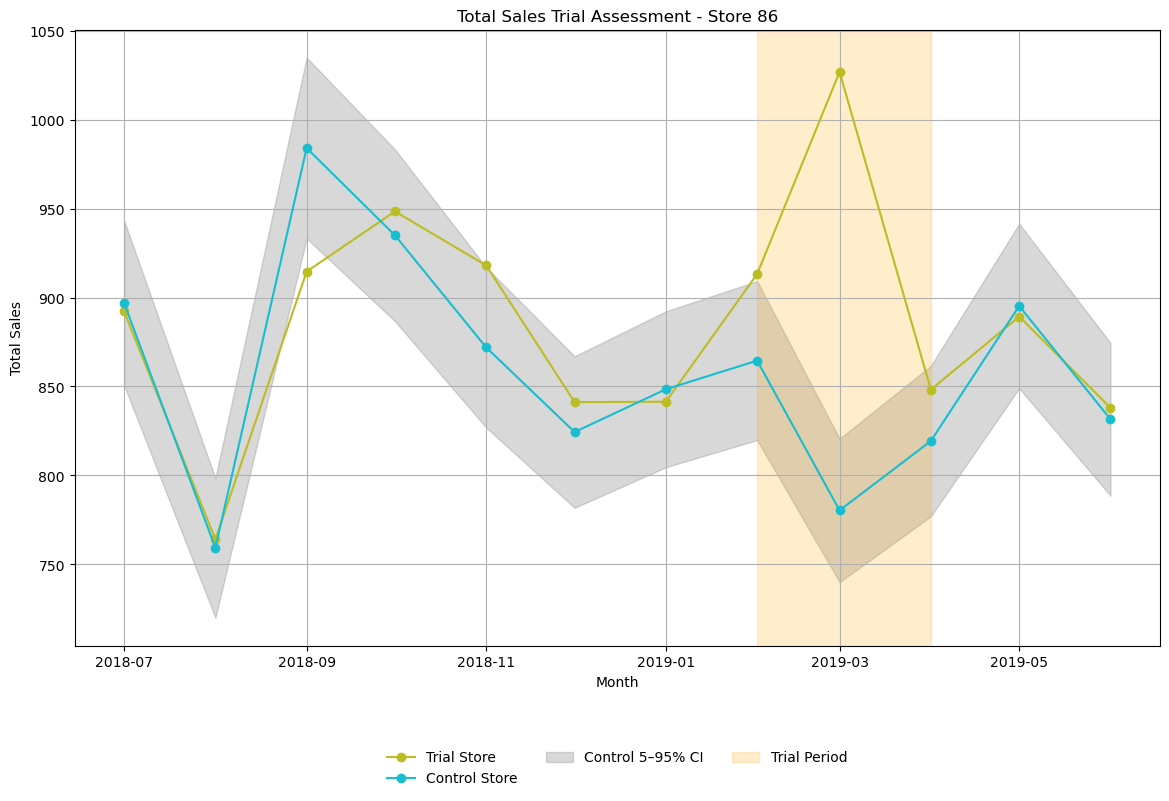

In [63]:
plt.figure(figsize=(14,8))

# Plot Trial Store and Control Store
plt.plot(trialAssessment_86.index, trialAssessment_86['Trial Sales'], label='Trial Store', marker='o', color='tab:olive')
plt.plot(trialAssessment_86.index, trialAssessment_86['Control Sales'], label='Control Store', marker='o', color='tab:cyan')

# Shading area for confidence interval
plt.fill_between(trialAssessment_86.index, trialAssessment_86['Control 5th percentile'], trialAssessment_86['Control 95th percentile'], 
                 color='gray', alpha=0.3, label='Control 5–95% CI')

# Highlight trial period
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-01'), color='orange', alpha=0.2, label='Trial Period')

plt.title('Total Sales Trial Assessment - Store 86')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.show()

The trial period is highlighted in orange. Results show that trial store 86 performed significantly differently from its control store, falling outside the 5%–95% confidence interval of the control store for two of the three trial months. Despite this, the total sales of the trial store increased during the trial period.

#### Customer Assessment for Store 86

Next, we’ll assess the trial’s impact on the **number of customers**.

In [64]:
# Scale pre‐trial control customers to match pre‐trial trial store customers
trial_customers_sum_86 = pastSales_86[pastSales_86['store_type']=='Trial Store']['no_Customers'].sum()
control_customers_sum_86 = pastSales_86[pastSales_86['store_type']=='Control Store']['no_Customers'].sum()
scalingFactorForControlCust_86 = trial_customers_sum_86 / control_customers_sum_86
scalingFactorForControlCust_86

np.float64(1.0)

In [65]:
# Apply the scaling factor
scaledControlCustomers_86 = measureOverTimeSales_86[measureOverTimeSales_86['STORE_NBR']==control_store_86].copy()
scaledControlCustomers_86['Control_Customers'] = scaledControlCustomers_86['no_Customers'] * scalingFactorForControlCust_86
scaledControlCustomers_86['TransactionMonth'] = pd.to_datetime(scaledControlCustomers_86['YEARMONTH'].astype(str), format='%Y%m')
scaledControlCustomers_86.head(3)

,STORE_NBR,YEARMONTH,Total Sales,no_Customers,trans_per_customer,chips_per_customer,average_price,TransactionMonth,Control_Customers
1793,155,201807,924.6,101,1.217822,2.032520,3.698400,2018-07-01,101.0
1794,155,201808,782.7,91,1.307692,1.924370,3.417904,2018-08-01,91.0
1795,155,201809,1014.4,103,1.398058,2.013889,3.497931,2018-09-01,103.0


In [66]:
# Calculate the percentage difference between scaled control sales and trial sales
trial_customers_series_86 = measureOverTimeSales_86[measureOverTimeSales_86['STORE_NBR']==trial_store_86]['no_Customers'].reset_index(drop=True)

percentageDiffCust_86 = pd.concat([scaledControlCustomers_86[['YEARMONTH','Control_Customers']].reset_index(drop=True), trial_customers_series_86], axis=1)
percentageDiffCust_86.rename(columns={'no_Customers':'Trial_Customers'}, inplace=True)
percentageDiffCust_86['percentageDiff'] = abs(percentageDiffCust_86['Control_Customers'] - percentageDiffCust_86['Trial_Customers']) / percentageDiffCust_86['Control_Customers']
percentageDiffCust_86.head(3)

,YEARMONTH,Control_Customers,Trial_Customers,percentageDiff
0,201807,101.0,99,0.019802
1,201808,91.0,94,0.032967
2,201809,103.0,103,0.000000


Let’s visually check whether the difference is significant.

Assuming the null hypothesis that the trial period is the same as the pre-trial period, we calculate the standard deviation from the scaled percentage differences during the pre-trial period.


In [67]:
# Standard deviation and t-values
stdDevCust_86 = stdev(percentageDiffCust_86[percentageDiffCust_86['YEARMONTH']<201902]['percentageDiff'])
percentageDiffCust_86['T_value'] = (percentageDiffCust_86['percentageDiff'] - 0) / stdDevCust_86

In [68]:
# Trial and control store number of customers
controlCustomers_86 = scaledControlCustomers_86[['TransactionMonth','Control_Customers']].copy()
controlCustomers_86.set_index('TransactionMonth', inplace=True)
controlCustomers_86.rename(columns={'Control_Customers':'Control Customers'}, inplace=True)
# Control store 95th percentile
controlCustomers_86['Control 95th % CI'] = controlCustomers_86['Control Customers'] * (1 + stdDevCust_86*2)
## Control store 5th percentile
controlCustomers_86['Control 5th % CI'] = controlCustomers_86['Control Customers'] * (1 - stdDevCust_86*2)

trialCustomers_86 = measureOverTimeSales_86[measureOverTimeSales_86['STORE_NBR']==trial_store_86][['TransactionMonth','no_Customers']].copy()
trialCustomers_86.set_index('TransactionMonth', inplace=True)
trialCustomers_86.rename(columns={'no_Customers':'Trial Customers'}, inplace=True)

# Merge trial store as well to the control store dataframe
trial_86_Customer_Assessment = pd.merge(controlCustomers_86, trialCustomers_86, left_index=True, right_index=True)
trial_86_Customer_Assessment.head(3)

,Control Customers,Control 95th % CI,Control 5th % CI,Trial Customers
TransactionMonth,,,,
2018-07-01,101.0,103.158864,98.841136,99
2018-08-01,91.0,92.945115,89.054885,94
2018-09-01,103.0,105.201614,100.798386,103


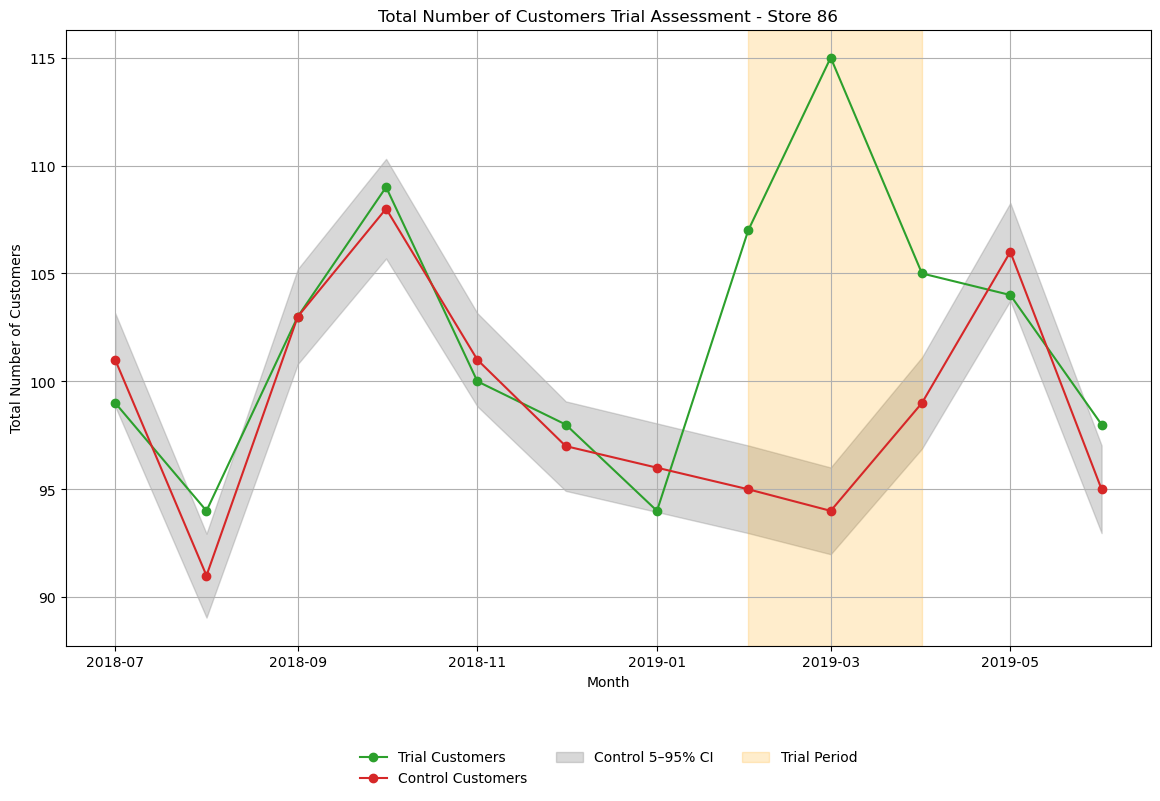

In [69]:
plt.figure(figsize=(14,8))

# Plot Trial Store and Control Store
plt.plot(trial_86_Customer_Assessment.index, trial_86_Customer_Assessment['Trial Customers'], label='Trial Customers', marker='o', color='tab:green')
plt.plot(trial_86_Customer_Assessment.index, trial_86_Customer_Assessment['Control Customers'], label='Control Customers', marker='o', color='tab:red')

# Shading area for confidence interval
plt.fill_between(trial_86_Customer_Assessment.index, trial_86_Customer_Assessment['Control 5th % CI'], trial_86_Customer_Assessment['Control 95th % CI'],
                 color='gray', alpha=0.3, label='Control 5–95% CI')

# Highlight trial period
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-01'), color='orange', alpha=0.2, label='Trial Period')

plt.title('Total Number of Customers Trial Assessment - Store 86')
plt.xlabel('Month')
plt.ylabel('Total Number of Customers')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.show()

The trial period is highlighted in orange. The number of customers appears to have increased substantially over the three months, suggesting that the trial boosted patronage in store 86, even though sales did not increase significantly.

We should consult the Category Manager to check if any special promotions in the trial store may have lowered prices, potentially affecting the results.


### Trial Store 88

In [70]:
trial_store_88 = 88

# Correlation & magnitude
corr_Sales_88 = calculateCorrelation(preTrialMeasures, 'Total Sales', trial_store_88)
magnitude_Sales_88 = calculateMagnitudeDistance(preTrialMeasures, 'Total Sales', trial_store_88)

corr_Customers_88 = calculateCorrelation(preTrialMeasures, 'no_Customers', trial_store_88)
magnitude_Customers_88 = calculateMagnitudeDistance(preTrialMeasures, 'no_Customers', trial_store_88)

In [71]:
score_Sales_88 = pd.concat([corr_Sales_88, magnitude_Sales_88['Magnitude']], axis = 1)
score_Sales_88.head(3)

,Store1,Store2,corr_measure,Magnitude
0,88,1,0.813636,0.548959
1,88,2,-0.067927,0.541212
2,88,3,-0.507847,0.458109


In [72]:
score_Customers_88 = pd.concat([corr_Customers_88, magnitude_Customers_88['Magnitude']], axis = 1)
score_Customers_88.head(3)

,Store1,Store2,corr_measure,Magnitude
0,88,1,0.305334,0.357143
1,88,2,-0.452379,0.285714
2,88,3,0.522884,0.683673


In [73]:
# Create a combined score composed of correlation and magnitude
# Weighted score
corr_weight = 0.5
score_Sales_88['scoreSales'] = corr_weight * score_Sales_88['corr_measure'] + (1 - corr_weight) * score_Sales_88['Magnitude']
score_Customers_88['scoreCustomers'] = corr_weight * score_Customers_88['corr_measure'] + (1 - corr_weight) * score_Customers_88['Magnitude']

score_Sales_88.set_index(['Store1', 'Store2'], inplace=True)
score_Customers_88.set_index(['Store1', 'Store2'], inplace=True)

# Combine scores across the drivers
score_Control_88 = pd.concat([score_Sales_88['scoreSales'], score_Customers_88['scoreCustomers']], axis=1)

# Add a new column 'finalControlScore' to 'score_Control'
score_Control_88['finalControlScore'] = 0.5 * (score_Control_88['scoreSales'] + score_Control_88['scoreCustomers'])
score_Control_88.sort_values(by='finalControlScore', ascending=False).head(5)

scoreSales  scoreCustomers  finalControlScore
Store1 Store2                                               
88     178       0.650803        0.707828           0.679316
       14        0.646064        0.685774           0.665919
       134       0.775084        0.540154           0.657619
       237       0.451974        0.777235           0.614604
       187       0.616752        0.594560           0.605656

In [74]:
# Select control store for trial store 88
control_store_88 = score_Control_88['finalControlScore'].idxmax()[1]
print("Control Store for Trial Store 88:", control_store_88)

Control Store for Trial Store 88: 178


We’ve identified store 178 as a suitable control store for trial store 88.  

As before, let's visually check whether the key drivers are similar in the pre-trial period.  
We’ll start by examining total sales.

In [75]:
# Trial and control assignment
pastSales_88 = preTrialMeasures.copy()
pastSales_88['store_type'] = pastSales_88['STORE_NBR'].apply(
    lambda x: 'Trial Store' if x==trial_store_88 else ('Control Store' if x==control_store_88 else 'Other Stores'))

pastSales_88['TransactionMonth'] = pd.to_datetime(pastSales_88['YEARMONTH'].astype(str), format='%Y%m')
pastSales_88['Month'] = pastSales_88['TransactionMonth'].dt.month_name().str[:3]
pastSales_88.head(3)

,STORE_NBR,YEARMONTH,Total Sales,no_Customers,trans_per_customer,chips_per_customer,average_price,store_type,TransactionMonth,Month
0,1,201807,206.9,49,1.061224,1.192308,3.337097,Other Stores,2018-07-01,Jul
1,1,201808,176.1,42,1.023810,1.255814,3.261111,Other Stores,2018-08-01,Aug
2,1,201809,278.8,59,1.050847,1.209677,3.717333,Other Stores,2018-09-01,Sep


In [76]:
# Plot Total Sales pre-trial
combinePlot_88 = pd.concat([
    pastSales_88[pastSales_88['store_type']=='Control Store'].set_index('Month')['Total Sales'].rename('Control Store Sales'),
    pastSales_88[pastSales_88['store_type']=='Trial Store'].set_index('Month')['Total Sales'].rename('Trial Store Sales'),
    pastSales_88[pastSales_88['store_type']=='Other Stores'].groupby('Month')['Total Sales'].mean().rename('Other Stores Sales')], axis=1)

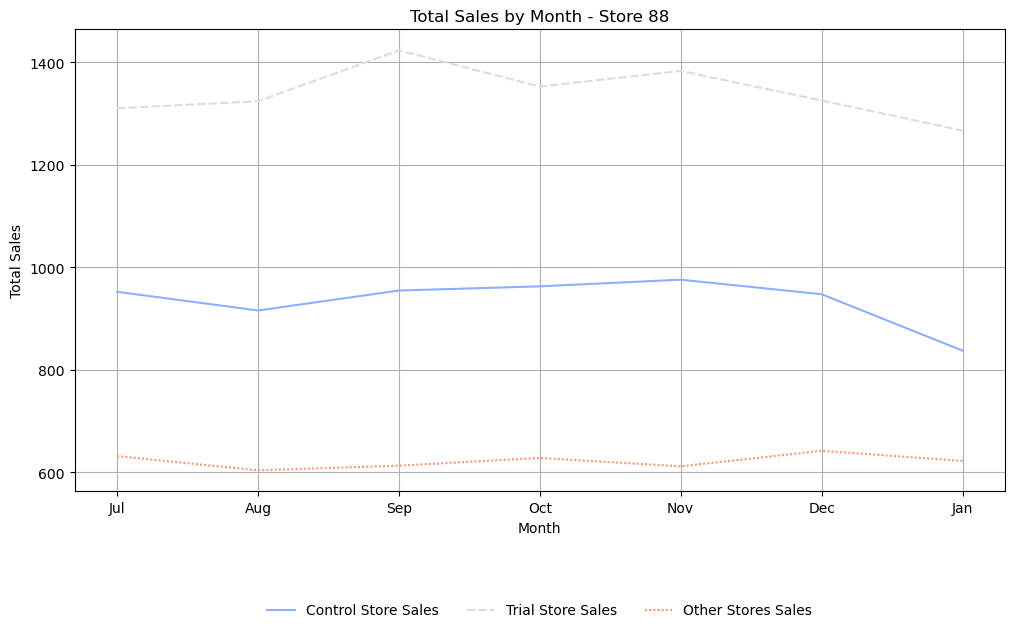

In [77]:
plt.figure(figsize=(12,6))
ax_88 = sns.lineplot(data=combinePlot_88, palette="coolwarm")
sns.move_legend(ax_88, "lower center", bbox_to_anchor=(0.5, -.3), ncol=3, frameon=False)
plt.title("Total Sales by Month - Store 88")
plt.ylabel("Total Sales")
plt.grid()
plt.show()

The trial store and its control store do not have similar total sales; the trial store is substantially above the control store.  

Next, we visually compare the trends in customer counts between the trial store, its control store, and other stores.

In [78]:
# Visual checks on trends based on the drivers
# Filter each store type
control_Customer_Plot_88 = pastSales_88.loc[pastSales_88['store_type'] == 'Control Store', ['Month', 'no_Customers']].set_index('Month')
trial_Customer_Plot_88 = pastSales_88.loc[pastSales_88['store_type'] == 'Trial Store', ['Month', 'no_Customers']].set_index('Month')
other_Customer_Plot_88 = pastSales_88.loc[pastSales_88['store_type'] == 'Other Stores', ['Month', 'no_Customers']].groupby('Month').mean()

# Rename
control_Customer_Plot_88.rename(columns={'no_Customers':'Control Store Customers'}, inplace=True)
trial_Customer_Plot_88.rename(columns={'no_Customers':'Trial Store Customers'}, inplace=True)
other_Customer_Plot_88.rename(columns={'no_Customers':'Other Stores Customers'}, inplace=True)

# Combine into one DataFrame
combine_Customer_Plot_88 = pd.concat([control_Customer_Plot_88, trial_Customer_Plot_88, other_Customer_Plot_88], axis=1)

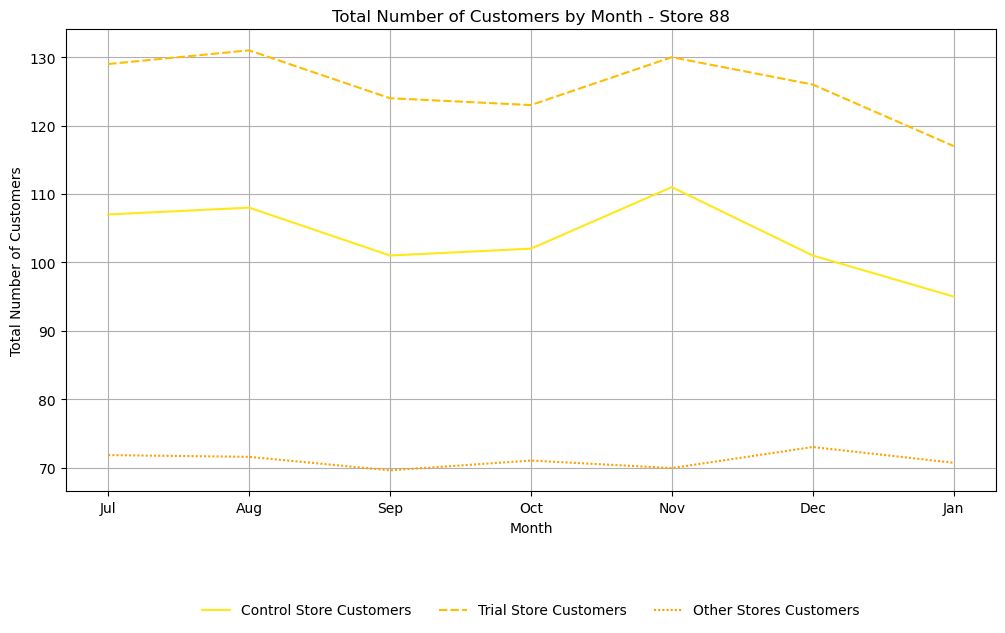

In [79]:
plt.figure(figsize=(12,6))
ax1_88 = sns.lineplot(data=combine_Customer_Plot_88, palette="Wistia")
sns.move_legend(ax1_88, "lower center", bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False)
plt.ylabel("Total Number of Customers")
plt.title('Total Number of Customers by Month - Store 88')
plt.grid()
plt.show()

The total number of customers of the control and trial stores are not similar.  

Let’s now assess the impact of the trial on sales.

#### Trial Assessment: Sales for Store 88

In [80]:
measureOverTimeSales_88 = measureOverTime.copy()
measureOverTimeSales_88['TransactionMonth'] = pd.to_datetime(measureOverTimeSales_88['YEARMONTH'].astype(str), format='%Y%m')

In [81]:
# Scale pre‐trial control sales to match pre‐trial trial store sales
trial_sales_sum_88 = pastSales_88[pastSales_88['store_type']=='Trial Store']['Total Sales'].sum()
control_sales_sum_88 = pastSales_88[pastSales_88['store_type']=='Control Store']['Total Sales'].sum()
scalingFactorForControlSales_88 = trial_sales_sum_88 / control_sales_sum_88
scalingFactorForControlSales_88

np.float64(1.4338146535258616)

In [82]:
# Apply scaling factor to control store in full measureOverTime
scaledControlSales_88 = measureOverTimeSales_88[measureOverTimeSales_88['STORE_NBR']==control_store_88].copy()
scaledControlSales_88['controlSales'] = scaledControlSales_88['Total Sales'] * scalingFactorForControlSales_88
scaledControlSales_88['TransactionMonth'] = pd.to_datetime(scaledControlSales_88['YEARMONTH'].astype(str), format='%Y%m')
scaledControlSales_88.head(3)

,STORE_NBR,YEARMONTH,Total Sales,no_Customers,trans_per_customer,chips_per_customer,average_price,TransactionMonth,controlSales
2069,178,201807,952.0,107,1.224299,2.015267,3.606061,2018-07-01,1364.991550
2070,178,201808,915.5,108,1.231481,1.902256,3.618577,2018-08-01,1312.657315
2071,178,201809,954.4,101,1.267327,2.078125,3.587970,2018-09-01,1368.432705


With comparable control sales, we can calculate the percentage difference between the scaled control sales and the trial store’s sales during the trial period.

In [83]:
# Calculate the percentage difference between scaled control sales and trial sales
trial_sales_series_88 = measureOverTimeSales_88[measureOverTimeSales_88['STORE_NBR']==trial_store_88]['Total Sales'].reset_index(drop=True)

percentageDiffSales_88 = scaledControlSales_88[['YEARMONTH','controlSales']].reset_index(drop=True)
percentageDiffSales_88 = pd.concat([percentageDiffSales_88, trial_sales_series_88], axis=1)
percentageDiffSales_88.rename(columns={'Total Sales':'Trial_Sales'}, inplace=True)
percentageDiffSales_88['percentageDiff'] = abs(percentageDiffSales_88['controlSales'] - percentageDiffSales_88['Trial_Sales'])/ percentageDiffSales_88['controlSales']
percentageDiffSales_88.head(3)

,YEARMONTH,controlSales,Trial_Sales,percentageDiff
0,201807,1364.991550,1310.0,0.040287
1,201808,1312.657315,1323.8,0.008489
2,201809,1368.432705,1423.0,0.039876


Assuming the null hypothesis that the trial period matches the pre-trial period, we calculate the standard deviation from the scaled percentage differences during the pre-trial period.

In [84]:
# Standard deviation from pre-trial period
stdDevSales_88 = stdev(percentageDiffSales_88[percentageDiffSales_88['YEARMONTH']<201902]['percentageDiff'])
stdDevSales_88

0.017074051922797567

In [85]:
# Note that there are 8 months in the pre-trial period - 1
degreesOfFreedom_88 = len(percentageDiffSales_88[percentageDiffSales_88['YEARMONTH']<201902]) - 1

In [86]:
# Calculate t-values for trial months (Feb-Apr 2019)
percentageDiffSales_88['T_value'] = (percentageDiffSales_88['percentageDiff'] - 0) / stdDevSales_88
t_values_trial_88 = percentageDiffSales_88[(percentageDiffSales_88['YEARMONTH']>201901) & (percentageDiffSales_88['YEARMONTH']<201905)]['T_value']
print("t-values for trial months:", t_values_trial_88.tolist())

t-values for trial months: [7.163302113936083, 1.8446986858037429, 3.089489189955397]


In [87]:
# 95th percentile of t distribution
t95_88 = t.isf(0.05, degreesOfFreedom_88)
print("95th percentile of t-distribution:", t95_88)

95th percentile of t-distribution: 1.9431802805153024


In [88]:
## Trial and control store total sales
# Control store confidence interval
controlSales_88 = scaledControlSales_88[['TransactionMonth','controlSales']].copy()
controlSales_88.set_index('TransactionMonth', inplace=True)
controlSales_88.rename(columns = {'controlSales': 'Control Sales'}, inplace = True)

# Control store 95th percentile
controlSales_88['Control 95th percentile'] = controlSales_88['Control Sales'] * (1 + stdDevSales_88*2)

# Control store 5th percentile
controlSales_88['Control 5th percentile'] = controlSales_88['Control Sales'] * (1 - stdDevSales_88*2)

In [89]:
# Merge trial sales
trialSales_88 = measureOverTimeSales_88[measureOverTimeSales_88['STORE_NBR']==trial_store_88][['TransactionMonth','Total Sales']].copy()
trialSales_88.set_index('TransactionMonth', inplace=True)
trialSales_88.rename(columns={'Total Sales':'Trial Sales'}, inplace=True)

trialAssessment_88 = pd.merge(controlSales_88, trialSales_88, left_index=True, right_index=True)
trialAssessment_88.head(3)

,Control Sales,Control 95th percentile,Control 5th percentile,Trial Sales
TransactionMonth,,,,
2018-07-01,1364.991550,1411.603423,1318.379677,1310.0
2018-08-01,1312.657315,1357.482074,1267.832557,1323.8
2018-09-01,1368.432705,1415.162087,1321.703323,1423.0


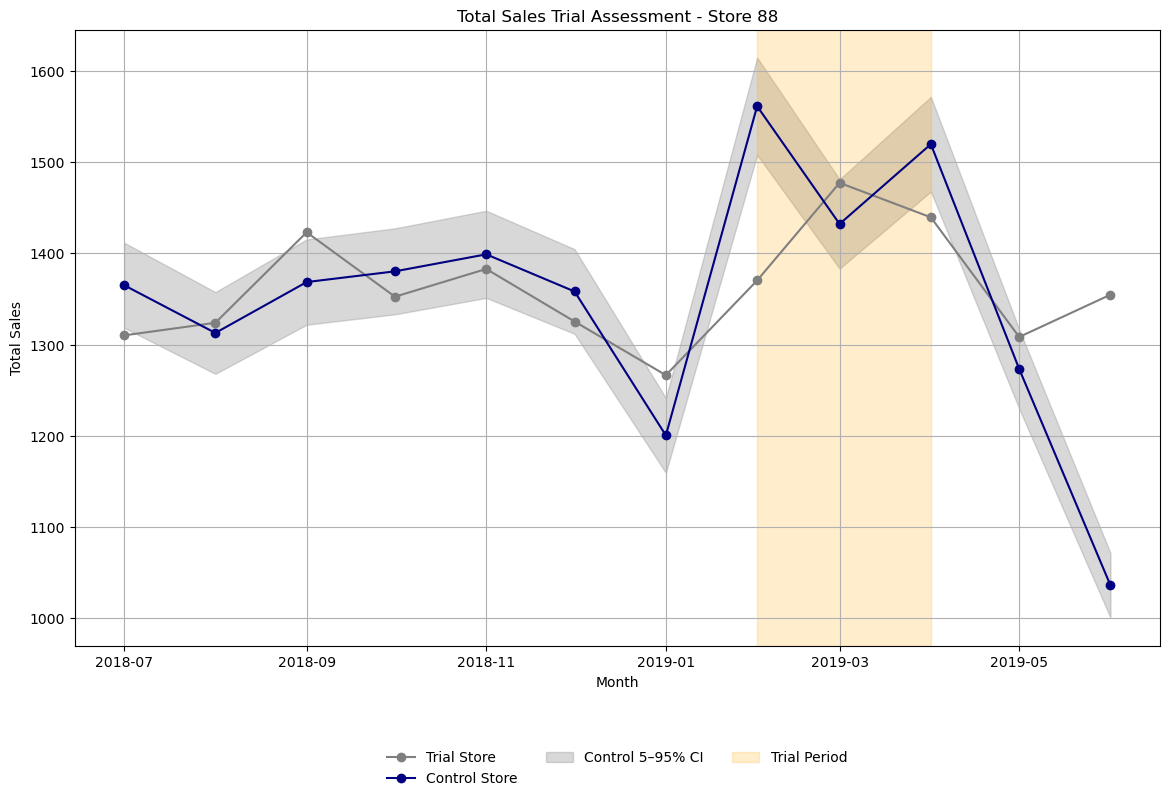

In [90]:
plt.figure(figsize=(14,8))

# Plot Trial Store and Control Store
plt.plot(trialAssessment_88.index, trialAssessment_88['Trial Sales'], label='Trial Store', marker='o', color='tab:gray')
plt.plot(trialAssessment_88.index, trialAssessment_88['Control Sales'], label='Control Store', marker='o', color='navy')

# Shading area for confidence interval
plt.fill_between(trialAssessment_88.index, trialAssessment_88['Control 5th percentile'], trialAssessment_88['Control 95th percentile'], 
                 color='gray', alpha=0.3, label='Control 5–95% CI')

# Highlight trial period
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-01'), color='orange', alpha=0.2, label='Trial Period')

plt.title('Total Sales Trial Assessment - Store 88')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.show()

The results indicate that the trial in store 88 is significantly different from its control store during the trial period, as the trial store’s performance falls outside the 5%–95% confidence interval of the control store for two of the three trial months. Only one month remains within the control store’s interval.  

Let’s also examine the assessment for the number of customers.

#### Trial Customer Assessment for Store 88

Next, we’ll assess the trial’s impact on the number of customers.

In [91]:
# Scale pre‐trial control customers to match pre‐trial trial store customers
trial_customers_sum_88 = pastSales_88[pastSales_88['store_type']=='Trial Store']['no_Customers'].sum()
control_customers_sum_88 = pastSales_88[pastSales_88['store_type']=='Control Store']['no_Customers'].sum()
scalingFactorForControlCust_88 = trial_customers_sum_88 / control_customers_sum_88
scalingFactorForControlCust_88

np.float64(1.2137931034482758)

In [92]:
# Apply the scaling factor
scaledControlCustomers_88 = measureOverTimeSales_88[measureOverTimeSales_88['STORE_NBR']==control_store_88].copy()
scaledControlCustomers_88['Control_Customers'] = scaledControlCustomers_88['no_Customers'] * scalingFactorForControlCust_88
scaledControlCustomers_88['TransactionMonth'] = pd.to_datetime(scaledControlCustomers_88['YEARMONTH'].astype(str), format='%Y%m')
scaledControlCustomers_88.head(3)

,STORE_NBR,YEARMONTH,Total Sales,no_Customers,trans_per_customer,chips_per_customer,average_price,TransactionMonth,Control_Customers
2069,178,201807,952.0,107,1.224299,2.015267,3.606061,2018-07-01,129.875862
2070,178,201808,915.5,108,1.231481,1.902256,3.618577,2018-08-01,131.089655
2071,178,201809,954.4,101,1.267327,2.078125,3.587970,2018-09-01,122.593103


In [93]:
# Calculate the percentage difference between scaled control sales and trial sales
trial_customers_series_88 = measureOverTimeSales_88[measureOverTimeSales_88['STORE_NBR']==trial_store_88]['no_Customers'].reset_index(drop=True)

percentageDiffCust_88 = pd.concat([scaledControlCustomers_88[['YEARMONTH','Control_Customers']].reset_index(drop=True), trial_customers_series_88], axis=1)
percentageDiffCust_88.rename(columns={'no_Customers':'Trial_Customers'}, inplace=True)
percentageDiffCust_88['percentageDiff'] = abs(percentageDiffCust_88['Control_Customers'] - percentageDiffCust_88['Trial_Customers']) / percentageDiffCust_88['Control_Customers']
percentageDiffCust_88.head(3)

,YEARMONTH,Control_Customers,Trial_Customers,percentageDiff
0,201807,129.875862,129,0.006744
1,201808,131.089655,131,0.000684
2,201809,122.593103,124,0.011476


In [94]:
# Standard deviation and t-values
stdDevCust_88 = stdev(percentageDiffCust_88[percentageDiffCust_88['YEARMONTH']<201902]['percentageDiff'])
percentageDiffCust_88['T_value'] = (percentageDiffCust_88['percentageDiff'] - 0) / stdDevCust_88

In [95]:
# Trial and control store number of customers
# Control customer confidence interval
controlCustomers_88 = scaledControlCustomers_88[['TransactionMonth','Control_Customers']].copy()
controlCustomers_88.set_index('TransactionMonth', inplace=True)
controlCustomers_88.rename(columns = {'Control_Customers': 'Control Customers'}, inplace = True)
# Control store 95th percentile
controlCustomers_88['Control 95th % CI'] = controlCustomers_88['Control Customers'] * (1 + stdDevCust_88*2)
# Control store 5th percentile
controlCustomers_88['Control 5th % CI'] = controlCustomers_88['Control Customers'] * (1 - stdDevCust_88*2)

trialCustomers_88 = measureOverTimeSales_88[measureOverTimeSales_88['STORE_NBR']==trial_store_88][['TransactionMonth','no_Customers']].copy()
trialCustomers_88.set_index('TransactionMonth', inplace=True)
trialCustomers_88.rename(columns={'no_Customers':'Trial Customers'}, inplace=True)

# Merge trial store as well to the control store dataframe
trial_88_Customer_Assessment = pd.merge(controlCustomers_88, trialCustomers_88, left_index=True, right_index=True)
trial_88_Customer_Assessment.head(3)

,Control Customers,Control 95th % CI,Control 5th % CI,Trial Customers
TransactionMonth,,,,
2018-07-01,129.875862,133.101414,126.650310,129
2018-08-01,131.089655,134.345352,127.833958,131
2018-09-01,122.593103,125.637783,119.548424,124


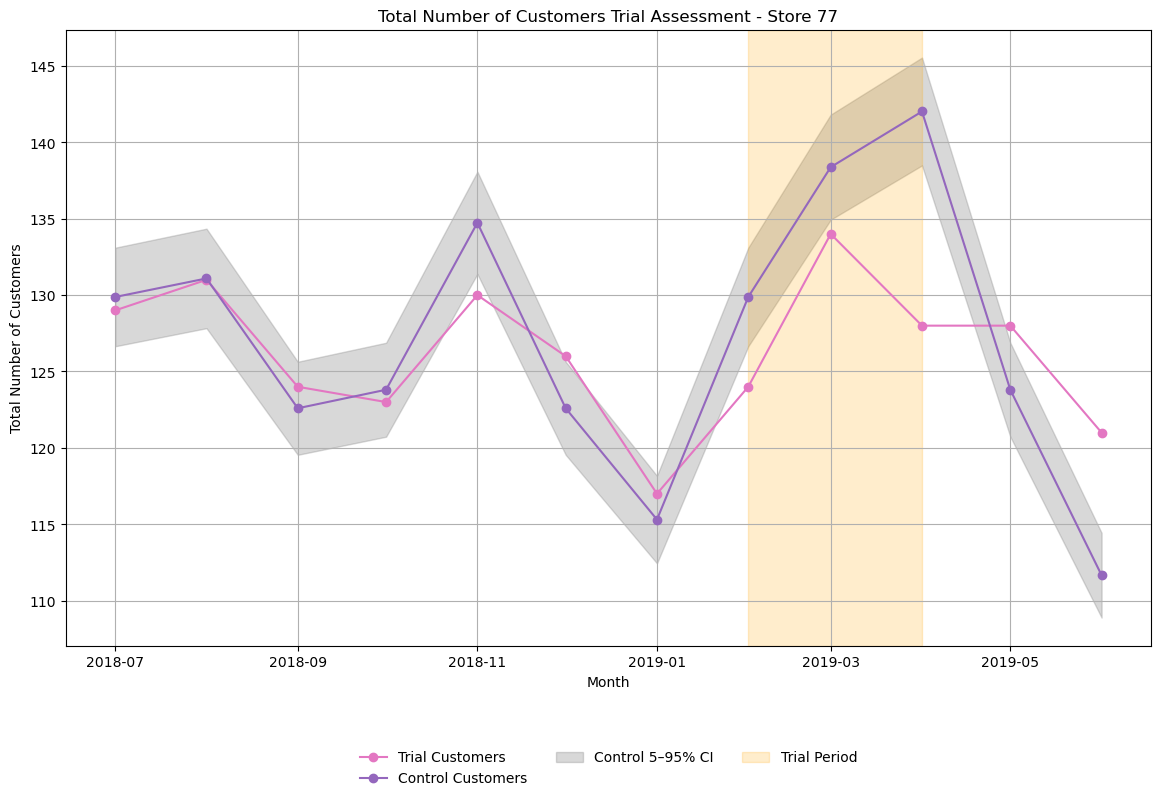

In [96]:
plt.figure(figsize=(14,8))

# Plot Trial Store and Control Store
plt.plot(trial_88_Customer_Assessment.index, trial_88_Customer_Assessment['Trial Customers'], label='Trial Customers', marker='o', color='tab:pink')
plt.plot(trial_88_Customer_Assessment.index, trial_88_Customer_Assessment['Control Customers'], label='Control Customers', marker='o', color='tab:purple')

# Shading area for confidence interval
plt.fill_between(trial_88_Customer_Assessment.index, trial_88_Customer_Assessment['Control 5th % CI'], trial_88_Customer_Assessment['Control 95th % CI'],
                 color='gray', alpha=0.3, label='Control 5–95% CI')

# Highlight trial period
plt.axvspan(pd.to_datetime('2019-02-01'), pd.to_datetime('2019-04-01'), color='orange', alpha=0.2, label='Trial Period')

plt.title('Total Number of Customers Trial Assessment - Store 77')
plt.xlabel('Month')
plt.ylabel('Total Number of Customers')
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False)
plt.show()

The total number of customers during the trial period in the trial store is significantly lower than in the control store for two of the three months, indicating a negative effect of the trial. The trial store’s performance falls outside the 5%–95% confidence interval of the control store.

## Conclusion

We identified **stores 233, 155, and 178** as the most suitable control stores for the trial stores **77, 86, and 88**, respectively.

* **Trial Store 77** showed a clear and significant improvement compared to its control store. Both sales and customer numbers were above the 5%–95% confidence interval for two out of the three trial months, indicating a positive impact from the trial initiative.
* **Trial Store 86** experienced an increase in customer count, but sales did not rise significantly. This suggests that while foot traffic improved, it did not translate into higher spending per customer. Further discussion with the **Category Manager** is recommended to determine whether promotional or pricing strategies influenced these results.
* **Trial Store 88** presented mixed outcomes — higher sales compared to the control store but a significant decline in customer numbers. This indicates that the trial may have driven higher spending per customer while reducing overall visits.

Overall, the trial demonstrated **a positive but varied impact** across stores.
These findings highlight the importance of selecting representative control stores and evaluating trial performance from multiple perspectives, including both sales and customer behavior.